In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

In [ ]:
# Версии библиотек
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

## Установка Seed

In [9]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Аугментация данных

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_ds  = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=0)

## Модель (тот же энкодер, что и в BYOL) + Линейная голова

In [10]:
class Encoder(nn.Module):
    def __init__(self, rep_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten()
        )
        self.fc = nn.Linear(128, rep_dim)
    def forward(self, x): return self.fc(self.net(x))

class SupervisedModel(nn.Module):
    def __init__(self, rep_dim=128, num_classes=10):
        super().__init__()
        self.encoder = ConvEncoder(rep_dim)
        self.classifier = nn.Linear(rep_dim, num_classes)
    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

## Функция обучения

In [6]:
def train_supervised(model, train_loader, test_loader, device, epochs=10, lr=1e-3):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_accs = []

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            running_loss += loss.item() * x.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        acc = evaluate_accuracy(model, test_loader, device)
        train_losses.append(avg_loss)
        test_accs.append(acc)
        print(f"Epoch {epoch}: loss={avg_loss:.4f}, test_acc={acc:.2f}%")
    return train_losses, test_accs

def evaluate_accuracy(model, test_loader, device):
    # Оценка точности 
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

# Матрица ошибок

In [11]:
def plot_confusion_matrix(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Матрица ошибок — Supervised")
    plt.show()

## Параметры

In [12]:
model = SupervisedModel(rep_dim=128, num_classes=10)
epochs = 20
lr = 1e-3

## Обучение

In [13]:
train_losses, test_accs = train_supervised(model, train_loader, test_loader, device, epochs=epochs, lr=lr)

Epoch 1/20: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]


Epoch 1: loss=0.3159, test_acc=96.36%


Epoch 2/20: 100%|██████████| 469/469 [00:18<00:00, 24.71it/s]


Epoch 2: loss=0.0706, test_acc=92.59%


Epoch 3/20: 100%|██████████| 469/469 [00:19<00:00, 23.90it/s]


Epoch 3: loss=0.0493, test_acc=97.84%


Epoch 4/20: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s]


Epoch 4: loss=0.0382, test_acc=96.43%


Epoch 5/20: 100%|██████████| 469/469 [00:19<00:00, 24.30it/s]


Epoch 5: loss=0.0312, test_acc=97.39%


Epoch 6/20: 100%|██████████| 469/469 [00:19<00:00, 24.59it/s]


Epoch 6: loss=0.0258, test_acc=98.54%


Epoch 7/20: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]


Epoch 7: loss=0.0227, test_acc=97.80%


Epoch 8/20: 100%|██████████| 469/469 [00:19<00:00, 24.46it/s]


Epoch 8: loss=0.0202, test_acc=98.86%


Epoch 9/20: 100%|██████████| 469/469 [00:19<00:00, 24.23it/s]


Epoch 9: loss=0.0169, test_acc=98.26%


Epoch 10/20: 100%|██████████| 469/469 [00:19<00:00, 24.41it/s]


Epoch 10: loss=0.0160, test_acc=98.40%


Epoch 11/20: 100%|██████████| 469/469 [00:19<00:00, 24.29it/s]


Epoch 11: loss=0.0156, test_acc=98.18%


Epoch 12/20: 100%|██████████| 469/469 [00:18<00:00, 24.80it/s]


Epoch 12: loss=0.0132, test_acc=98.76%


Epoch 13/20: 100%|██████████| 469/469 [00:19<00:00, 24.41it/s]


Epoch 13: loss=0.0124, test_acc=98.97%


Epoch 14/20: 100%|██████████| 469/469 [00:19<00:00, 24.37it/s]


Epoch 14: loss=0.0088, test_acc=98.89%


Epoch 15/20: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]


Epoch 15: loss=0.0094, test_acc=97.92%


Epoch 16/20: 100%|██████████| 469/469 [00:19<00:00, 24.37it/s]


Epoch 16: loss=0.0105, test_acc=98.55%


Epoch 17/20: 100%|██████████| 469/469 [00:18<00:00, 24.88it/s]


Epoch 17: loss=0.0077, test_acc=98.81%


Epoch 18/20: 100%|██████████| 469/469 [00:19<00:00, 24.67it/s]


Epoch 18: loss=0.0095, test_acc=98.45%


Epoch 19/20: 100%|██████████| 469/469 [00:19<00:00, 24.58it/s]


Epoch 19: loss=0.0055, test_acc=98.90%


Epoch 20/20: 100%|██████████| 469/469 [00:19<00:00, 24.54it/s]


Epoch 20: loss=0.0088, test_acc=98.47%


## Графики

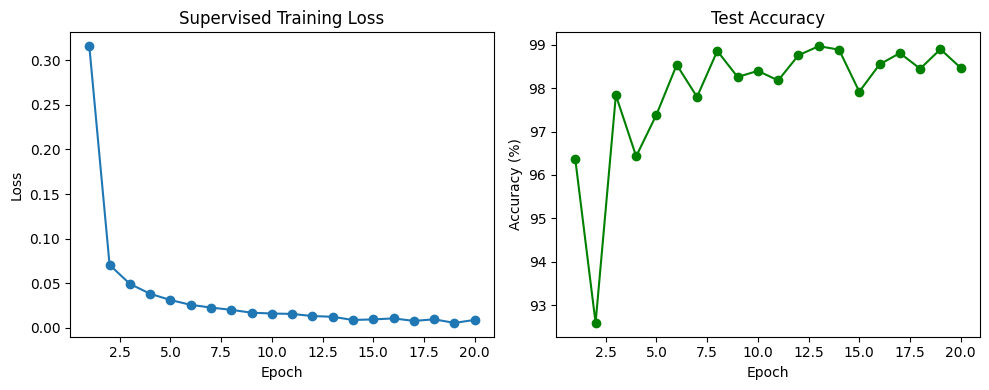

In [14]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.title("Supervised Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(range(1, len(test_accs)+1), test_accs, marker='o', color='green')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.tight_layout()
plt.show()

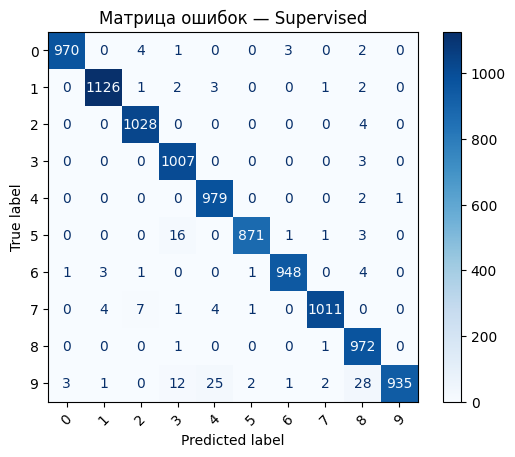

In [15]:
# Матрица ошибок
plot_confusion_matrix(model, test_loader, device)